In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nursery/nursery.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

2024-03-16 08:56:34.643479: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 08:56:34.643629: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 08:56:34.793419: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
nursery_df = pd.read_csv('/kaggle/input/nursery/nursery.csv')

In [4]:
nursery_df.head(10)

,parents,has_nurs,form,children,housing,finance,social,health,Target
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
5,usual,proper,complete,1,convenient,convenient,slightly_prob,not_recom,not_recom
6,usual,proper,complete,1,convenient,convenient,problematic,recommended,priority
7,usual,proper,complete,1,convenient,convenient,problematic,priority,priority
8,usual,proper,complete,1,convenient,convenient,problematic,not_recom,not_recom
9,usual,proper,complete,1,convenient,inconv,nonprob,recommended,very_recom


In [5]:
nursery_df.tail(10)

,parents,has_nurs,form,children,housing,finance,social,health,Target
12950,great_pret,very_crit,foster,more,critical,convenient,problematic,not_recom,not_recom
12951,great_pret,very_crit,foster,more,critical,inconv,nonprob,recommended,spec_prior
12952,great_pret,very_crit,foster,more,critical,inconv,nonprob,priority,spec_prior
12953,great_pret,very_crit,foster,more,critical,inconv,nonprob,not_recom,not_recom
12954,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,recommended,spec_prior
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior
12959,great_pret,very_crit,foster,more,critical,inconv,problematic,not_recom,not_recom


In [7]:
missing_values = nursery_df.iloc[:, :10].isnull().sum()

missing_values

 parents    0
has_nurs    0
form        0
children    0
housing     0
finance     0
social      0
health      0
Target      0
dtype: int64

In [6]:
nursery_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960 entries, 0 to 12959
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0    parents  12960 non-null  object
 1   has_nurs  12960 non-null  object
 2   form      12960 non-null  object
 3   children  12960 non-null  object
 4   housing   12960 non-null  object
 5   finance   12960 non-null  object
 6   social    12960 non-null  object
 7   health    12960 non-null  object
 8   Target    12960 non-null  object
dtypes: object(9)
memory usage: 911.4+ KB


In [8]:
nursery_df.describe()

,parents,has_nurs,form,children,housing,finance,social,health,Target
count,12960,12960,12960,12960,12960,12960,12960,12960,12960
unique,3,5,4,4,3,2,3,3,5
top,usual,proper,complete,1,convenient,convenient,nonprob,recommended,not_recom
freq,4320,2592,3240,3240,4320,6480,4320,4320,4320


Data value counts for categorical data

In [9]:
for column in nursery_df.select_dtypes(include=['object']).columns:
    print(nursery_df[column].value_counts())

 parents
usual          4320
pretentious    4320
great_pret     4320
Name: count, dtype: int64
has_nurs
proper         2592
less_proper    2592
improper       2592
critical       2592
very_crit      2592
Name: count, dtype: int64
form
complete      3240
completed     3240
incomplete    3240
foster        3240
Name: count, dtype: int64
children
1       3240
2       3240
3       3240
more    3240
Name: count, dtype: int64
housing
convenient    4320
less_conv     4320
critical      4320
Name: count, dtype: int64
finance
convenient    6480
inconv        6480
Name: count, dtype: int64
social
nonprob          4320
slightly_prob    4320
problematic      4320
Name: count, dtype: int64
health
recommended    4320
priority       4320
not_recom      4320
Name: count, dtype: int64
Target
not_recom     4320
priority      4266
spec_prior    4044
very_recom     328
recommend        2
Name: count, dtype: int64


In [10]:
print(nursery_df.columns)

Index([' parents', 'has_nurs', 'form', 'children', 'housing', 'finance',
       'social', 'health', 'Target'],
      dtype='object')


The distribution of each categorical

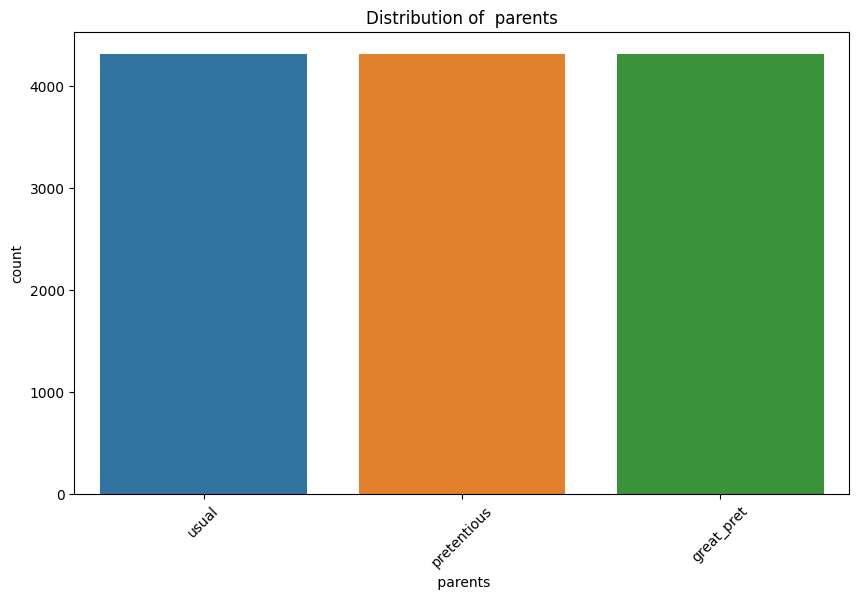

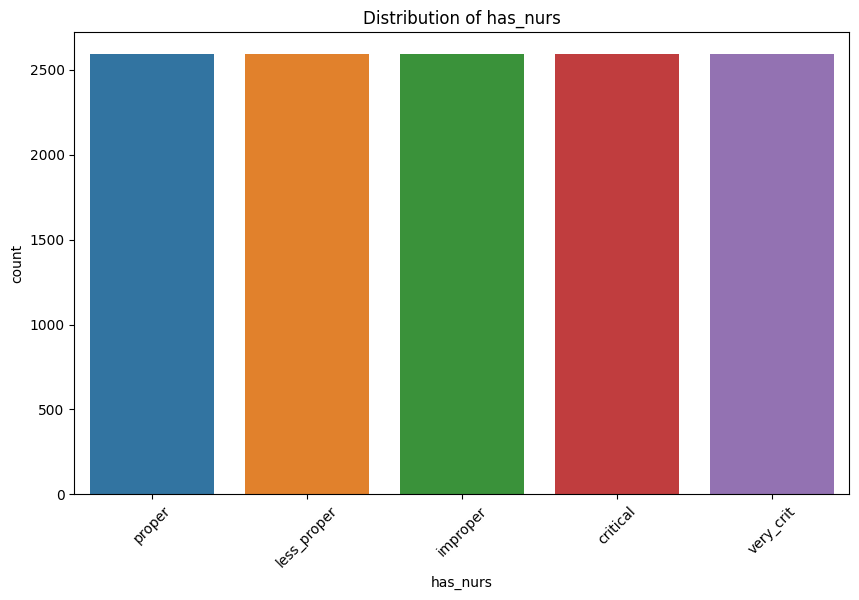

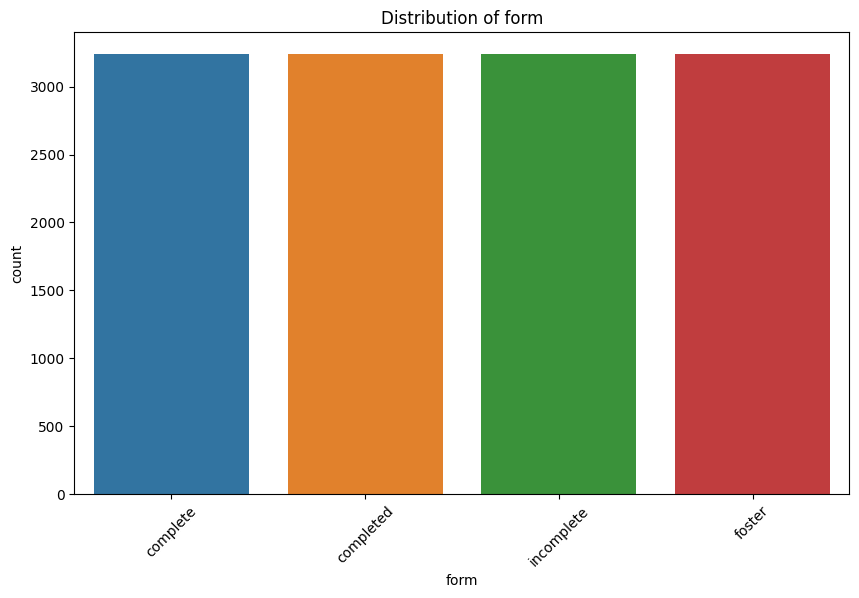

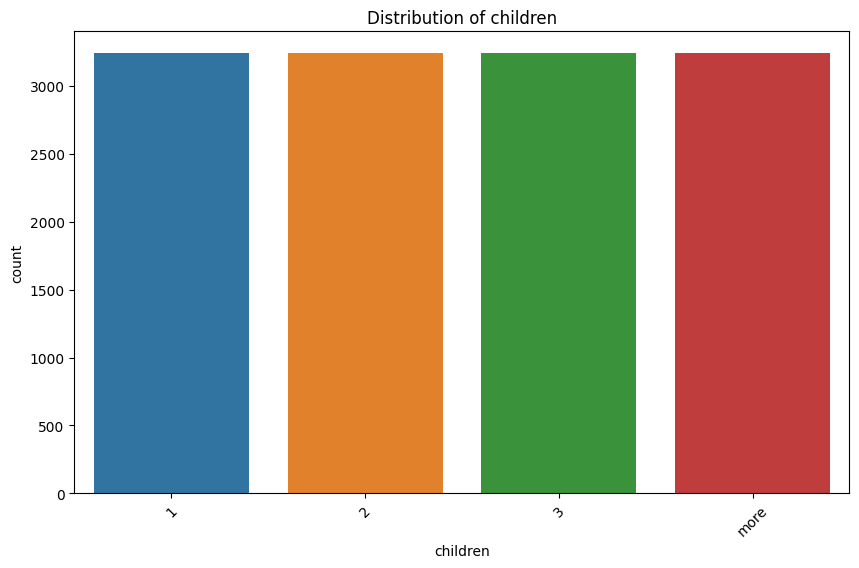

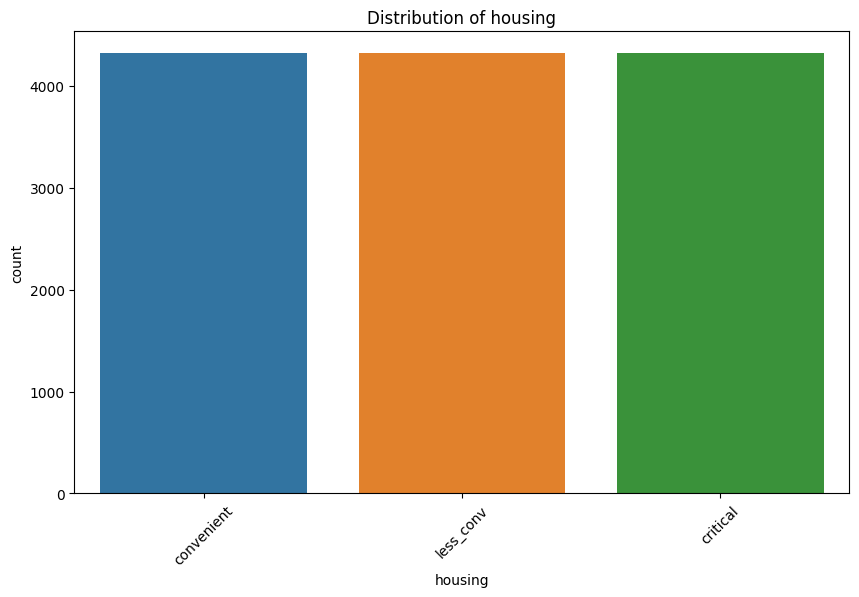

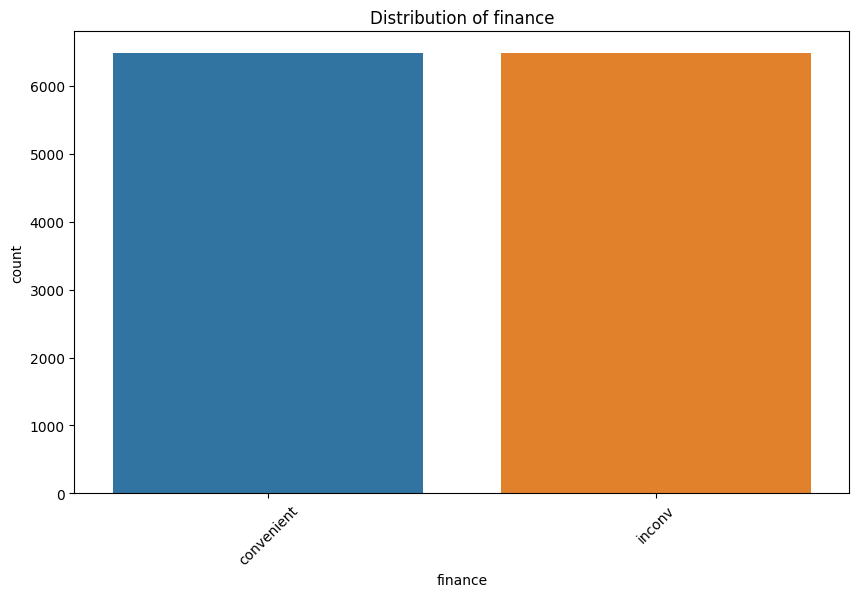

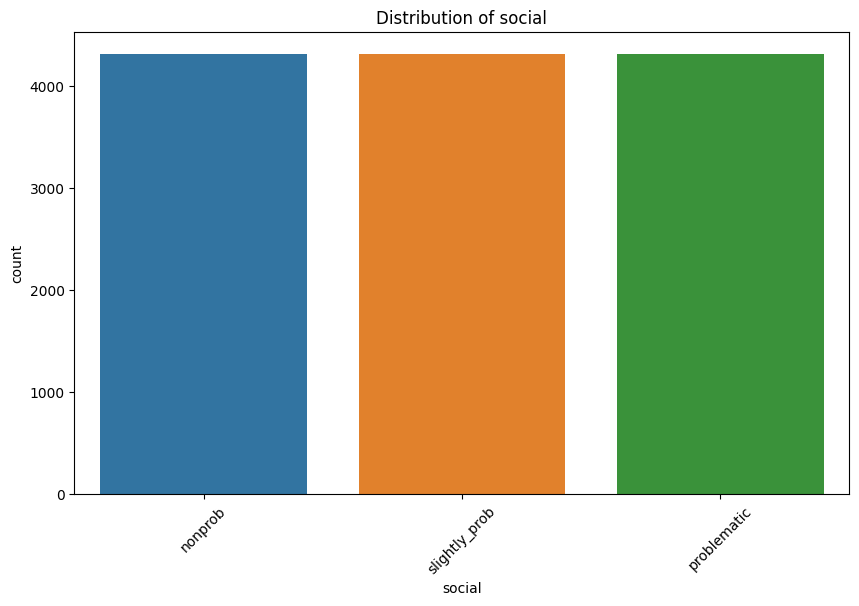

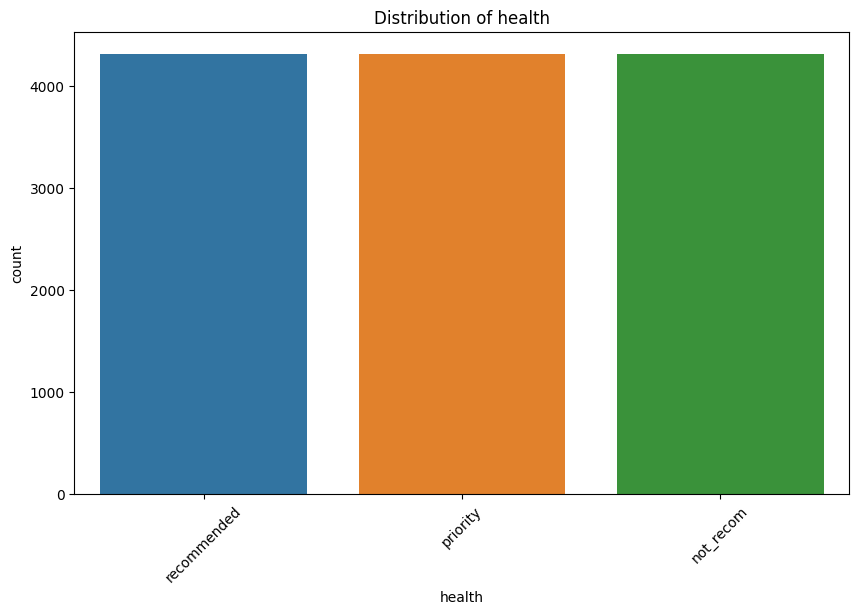

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Loop through each categorical column and create a bar plot
for column in nursery_df.columns[:-1]:  # Excluding the target variable
    plt.figure(figsize=(10, 6))
    sns.countplot(x=column, data=nursery_df)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
    plt.show()

Convert the entire nursery_df to numeric columns using one-hot encoding

In [15]:
nursery_df_numeric = pd.get_dummies(nursery_df)

# Check the first few rows of the newly converted DataFrame
print(nursery_df_numeric.head())

    parents_great_pret   parents_pretentious   parents_usual  \
0                False                 False            True   
1                False                 False            True   
2                False                 False            True   
3                False                 False            True   
4                False                 False            True   

   has_nurs_critical  has_nurs_improper  has_nurs_less_proper  \
0              False              False                 False   
1              False              False                 False   
2              False              False                 False   
3              False              False                 False   
4              False              False                 False   

   has_nurs_proper  has_nurs_very_crit  form_complete  form_completed  ...  \
0             True               False           True           False  ...   
1             True               False           True           Fals

In [19]:
nursery_df_numeric.head

<bound method NDFrame.head of         parents_great_pret   parents_pretentious   parents_usual  \
0                    False                 False            True   
1                    False                 False            True   
2                    False                 False            True   
3                    False                 False            True   
4                    False                 False            True   
...                    ...                   ...             ...   
12955                 True                 False           False   
12956                 True                 False           False   
12957                 True                 False           False   
12958                 True                 False           False   
12959                 True                 False           False   

       has_nurs_critical  has_nurs_improper  has_nurs_less_proper  \
0                  False              False                 False   
1              

In [20]:
# Correlation matrix
corr_matrix = nursery_df_numeric.corr()

# Display the correlation with the target variable, for example
print(corr_matrix['Target_very_recom'].sort_values(ascending=False))

Target_very_recom       1.000000
health_recommended      0.227885
housing_convenient      0.102826
 parents_usual          0.090320
has_nurs_less_proper    0.081552
has_nurs_proper         0.079096
children_1              0.074881
social_slightly_prob    0.056971
social_nonprob          0.056971
finance_convenient      0.053058
form_complete           0.040844
 parents_pretentious    0.023622
form_completed          0.020422
children_2              0.020422
has_nurs_improper       0.000491
Target_recommend       -0.002002
housing_less_conv      -0.009727
form_incomplete        -0.013615
children_3             -0.047651
children_more          -0.047651
form_foster            -0.047651
finance_inconv         -0.053058
has_nurs_very_crit     -0.080570
has_nurs_critical      -0.080570
housing_critical       -0.093099
Target_spec_prior      -0.108523
Target_priority        -0.112876
 parents_great_pret    -0.113943
health_not_recom       -0.113943
Target_not_recom       -0.113943
social_pro

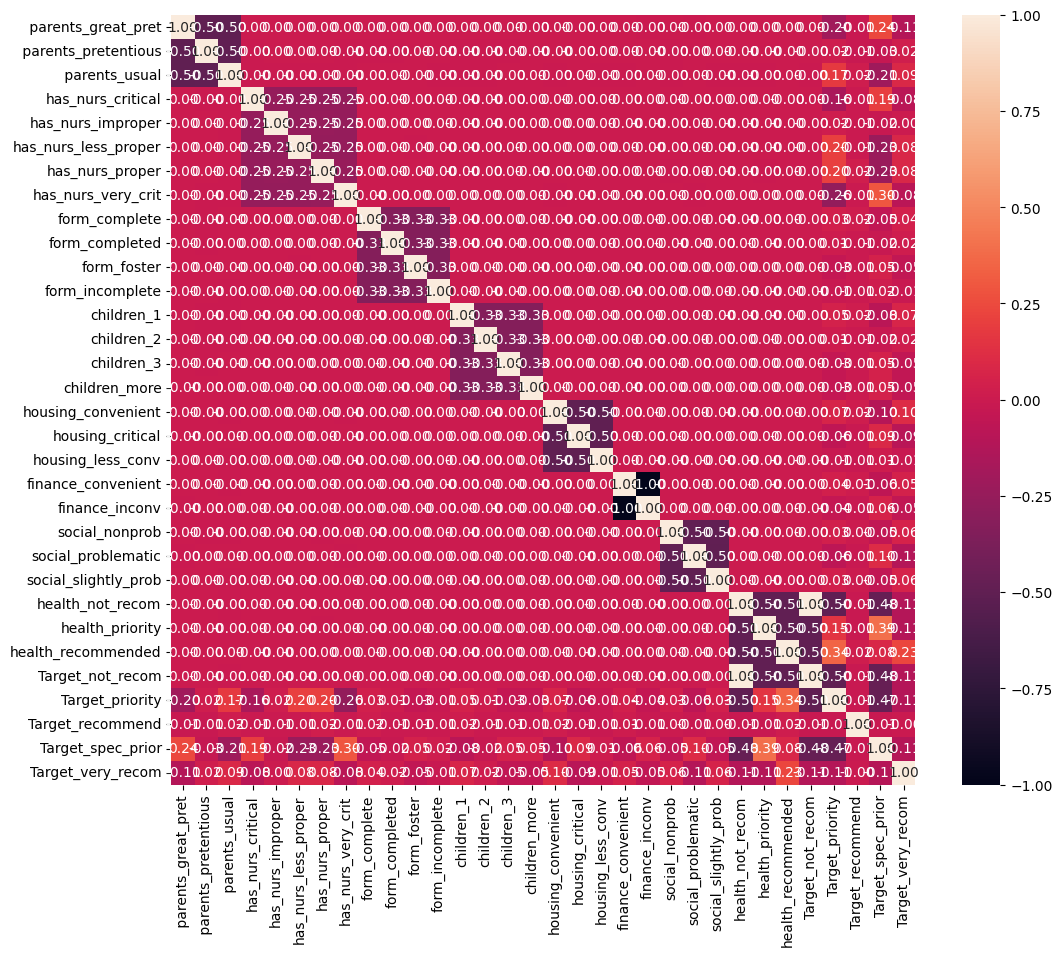

In [25]:
# Setting up the figure size for the heatmap
plt.figure(figsize=(12, 10))

# Creating a correlation heatmap using seaborn
# 'annot=True' displays the correlation values on the heatmap
# 'fmt=".2f"' formats the correlation values to two decimal places
sns.heatmap(corr_matrix, annot=True, fmt=".2f")

# Displaying the heatmap
plt.show()

Test Accuracy

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming 'target_column_name' is your target variable
X = nursery_df_numeric.drop('Target_very_recom', axis=1)
y = nursery_df_numeric['Target_very_recom']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Initialize the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the classifier on the training data
clf.fit(X_train_scaled, y_train)

# Predicting the Test set results
y_pred = clf.predict(X_test_scaled)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00
